# Plate Generator Notebook
### This notebook will demonstrate and execute the generation of synthetic license plates

In [31]:
# We will begin by importing necessary modules
import os
import random
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageChops, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import qrcode
import uuid
import random
import string
from PIL import Image

# Since we will be generating this on Google Colab, let's define the paths for our assets as well to make changing these later on easier.
documentation_dir = "documentation"
fonts_dir = "fonts"
images_dir = "images"

The generation process begins with selecting the style for the plate, including color palette and plate background.
We will be basing our choices on the Wikipedia page on Philippine License Plates: https://en.wikipedia.org/wiki/Vehicle_registration_plates_of_the_Philippines.

<figure>
  <img src="documentation/philippine_license_plates.jpg" alt="Philippine License Plates Color Palettes" width="300" />
  <figcaption>Fig 1. Philippine License Plates Color Palettes</figcaption>
</figure>

<figure>
  <img src="documentation/private_passenger_plates.jpg" alt="Private and Passenger License Plates" width="300" />
  <figcaption>Fig 2. Private and Passenger License Plates</figcaption>
</figure>

## Plate Styles

In [32]:
# The plate generation process starts by selecting a style for our plates.
# This block defines the various styles that a license plate may have.

# DEFAULT COLORS --------------------------------
# general
black = (0, 0, 0)
white = (255, 255, 255)
# vehicles
v_green = (3, 105, 55)
v_yellow = (246, 196, 13)
v_red = (249, 0, 0)
v_maroon = (134, 0, 0)
v_blue = (6, 41, 100)
# motorcycles
m_pink = (201, 100, 206)
m_green = (0, 123, 95)
m_gray = (119, 111, 103)
m_sky_blue = (106, 179, 230)
m_dark_blue = (47, 0, 140)
m_orange = (227, 82, 5)
m_red = (200, 16, 46)
m_brown = (139, 56, 26)
# government
g_blue = (10, 71, 173)
# rizal background (special case)
r_green = (21, 109, 82)
r_background = os.path.join(images_dir, "plate_backgrounds", "rizal.png")

# LICENSE PLATE STYLES --------------------------------
plate_styles = [
    # type, color1, color2
    ("vehicle", white, black),
    ("vehicle", white, v_green),
    ("vehicle", v_yellow, black),
    ("vehicle", white, v_red),
    ("vehicle", white, v_blue),
    ("motorcycle", white, black),
    ("motorcycle", white, m_pink),
    ("motorcycle", white, m_green),
    ("motorcycle", white, m_gray),
    ("motorcycle", white, m_sky_blue),
    ("motorcycle", white, m_dark_blue),
    ("motorcycle", white, m_orange),
    ("motorcycle", white, m_red),
    ("motorcycle", white, m_brown),
    ("government", g_blue, black),
    ("motorcycle_beveled", white, black),
    ("motorcycle_beveled", v_yellow, black),
    ("motorcycle_beveled", white, v_maroon),
    ("rizal", None, r_green),
]


## Plate Base

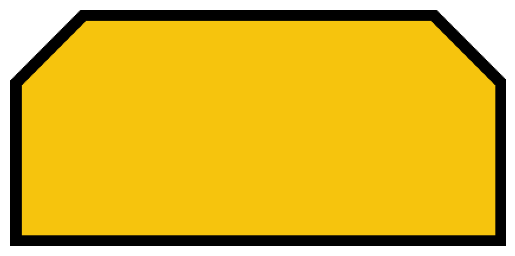

In [33]:
# Next, we will define the function that creates the base for our plates

# scale for debugging
debug_scale = 2
# vehicle
vw, vh = 280*debug_scale, 100*debug_scale
# motorcycle
mw, mh = 175*debug_scale, 100*debug_scale
# motorcycle beveled
maw, mah = 210*debug_scale, 100*debug_scale
corner = 30*debug_scale

def create_plate_base(width, height, border_color, fill_color, border_thickness=5, has_bevel=False):
    img = Image.new('RGBA', (width, height), (0, 0, 0, 0))
    draw = ImageDraw.Draw(img)
    
    b_color = border_color + (255,)
    f_color = fill_color + (255,)
    bt = border_thickness*debug_scale

    if has_bevel:
        # Calculate offset to keep visual thickness uniform on diagonal
        # Math: The shift along the axis = bt * (sqrt(2) - 1)
        shift = int(bt * (math.sqrt(2) - 1))
        
        # 1. Outer Polygon
        outer_points = [
            (0, corner),                # TL Bevel Start
            (corner, 0),                # TL Bevel End
            (width - corner, 0),        # TR Bevel Start
            (width, corner),            # TR Bevel End
            (width, height),            # BR
            (0, height)                 # BL
        ]
        
        # 2. Inner Polygon
        # We inset by 'bt' for straights, and 'corner + shift' for bevel intersections
        inner_points = [
            (bt, corner + shift),               
            (corner + shift, bt),               
            (width - corner - shift, bt),       
            (width - bt, corner + shift),       
            (width - bt, height - bt),          
            (bt, height - bt)                   
        ]
        
    else:
        # Standard Rectangle
        outer_points = [
            (0, 0), (width, 0), (width, height), (0, height)
        ]
        inner_points = [
            (bt, bt), (width - bt, bt), (width - bt, height - bt), (bt, height - bt)
        ]

    draw.polygon(outer_points, fill=b_color)
    draw.polygon(inner_points, fill=f_color)

    return img

def plot_image(img):
    if img.mode == 'L':
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    else:
        plt.imshow(img)
    plt.axis('off')
    plt.show()
    
plot_image(create_plate_base(maw, mah, black, v_yellow, has_bevel=True))

## License Plate Main Text Layer
### For later annotation, taking note of the letter positions will become extremely important. We'll take note of the letter segments in this implementation.

Text Layer Visualization


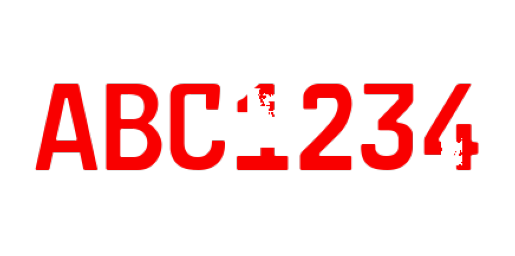

Character Annotations:
character: A


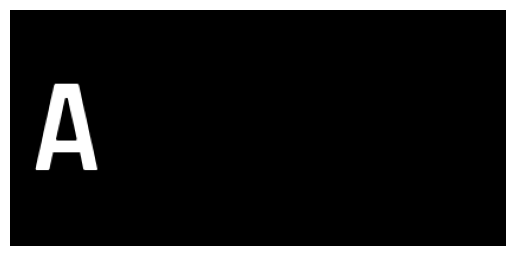

character: B


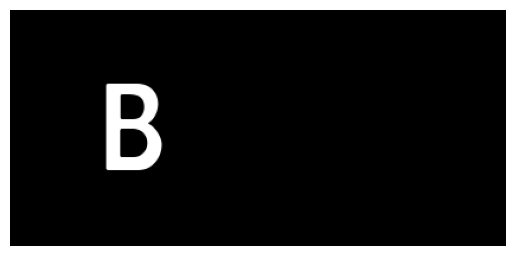

character: C


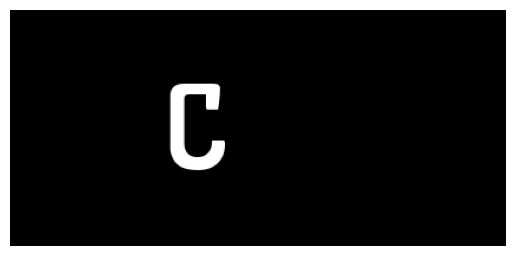

character: 1


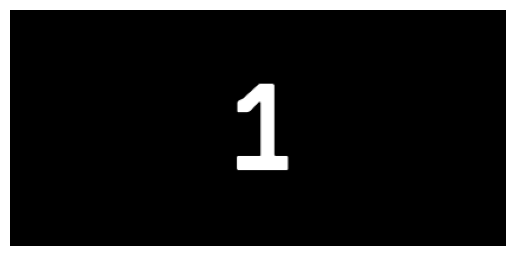

character: 2


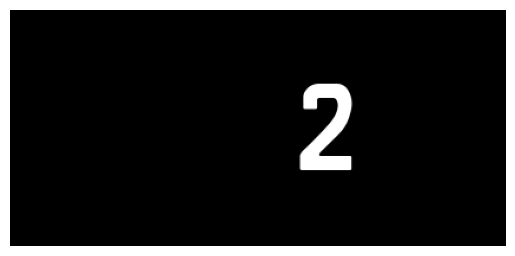

character: 3


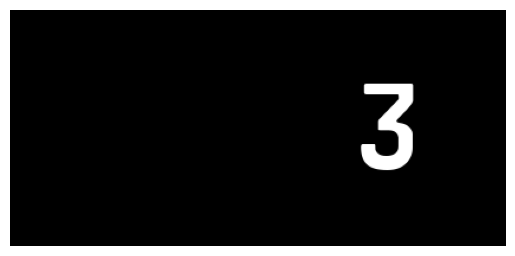

character: 4


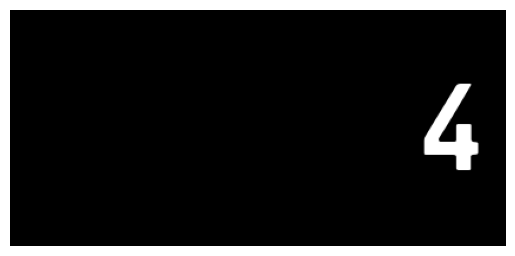

Text Layer with Annotations Overlay


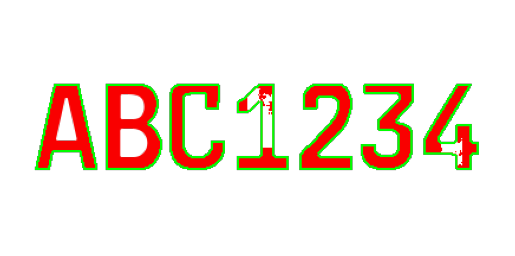

In [34]:
# Let's define our fonts first
fonts = [os.path.join(fonts_dir, f) for f in os.listdir(fonts_dir) if f.lower().endswith((".ttf", ".otf"))]

from PIL import Image, ImageDraw, ImageFont

font_scaling = 0.92
def get_scaled_font(draw, font_path, text, width, height, initial_size=10, step=2):
    """
    Returns the scaled ImageFont object that fits within width/height constraints.
    """
    max_width, max_height = width * font_scaling, height * font_scaling
    size = initial_size
    
    while True:
        font_obj = ImageFont.truetype(font_path, size)
        bbox = draw.textbbox((0, 0), text, font=font_obj)
        w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
        
        if w > max_width or h > max_height:
            break
        size += step
        
    return ImageFont.truetype(font_path, size - step)

# Before the actual text layer, we'll want a helper method that segments our characters into polygons.

def get_polygon_from_mask(mask):
    mask_array = np.array(mask)
    
    # Find contours
    # RETR_EXTERNAL: Retrieves only the extreme outer flags.
    # CHAIN_APPROX_SIMPLE: Compresses horizontal, vertical, and diagonal segments.
    contours, _ = cv2.findContours(mask_array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    polygons = []
    for cnt in contours:
        # Check for noise (ignore tiny specks)
        if cv2.contourArea(cnt) > 1:
            # Reshape from (N, 1, 2) -> (N, 2) and convert to standard python list
            poly_points = cnt.reshape(-1, 2).tolist()
            polygons.append(poly_points)
            
    return polygons

# I also want a method that simulates "paint chipping" on license plates,
# for this, i've created masks for chipping effects in images\obscurations_letter.
# We'll randomly chip at a letter with a probability of 30%

chip_dir = os.path.join(images_dir, "obscurations_letter")

chip_mask_files = [
    os.path.join(chip_dir, f)
    for f in os.listdir(chip_dir)
    if f.lower().endswith((".png", ".jpg"))
]

chipping_probability = 0.5
def apply_paint_chipping(letter_image, letter_mask):
    # Only apply chipping with 30% probability
    if random.random() > chipping_probability:
        return letter_image
    
    # Get letter bounding box
    bbox = letter_mask.getbbox()
    if not bbox:
        return letter_image  # No letter found in mask
    
    # Randomly select a chipping mask
    chip_mask_path = random.choice(chip_mask_files)
    chip_mask = Image.open(chip_mask_path).convert("L")
    
    # Get letter dimensions
    letter_width = bbox[2] - bbox[0]
    letter_height = bbox[3] - bbox[1]
    
    # Resize chipping mask to letter size (or slightly smaller for more realistic effect)
    scale_factor = random.uniform(0.3, 0.7)  # Chip size relative to letter
    chip_width = int(letter_width * scale_factor)
    chip_height = int(letter_height * scale_factor)
    
    chip_mask = chip_mask.resize((chip_width, chip_height), Image.Resampling.LANCZOS)
    
    # Create a mask for positioning the chip
    placement_mask = Image.new("L", letter_image.size, 0)
    
    # Random position within the letter bounds
    max_x = bbox[0] + letter_width - chip_width
    max_y = bbox[1] + letter_height - chip_height
    
    if max_x <= bbox[0] or max_y <= bbox[1]:
        return letter_image  # Letter too small for chipping
    
    pos_x = random.randint(bbox[0], max_x)
    pos_y = random.randint(bbox[1], max_y)
    
    # Paste chip mask onto placement mask
    placement_mask.paste(chip_mask, (pos_x, pos_y))
    
    # Apply the chipping effect by removing paint where chip mask is white
    # Convert images to RGBA for alpha manipulation
    text_layer_rgba = letter_image.convert("RGBA")
    chip_effect = Image.new("RGBA", text_layer_rgba.size, (0, 0, 0, 0))
    
    # Create alpha mask: where chip mask is white, set alpha to 0 (transparent)
    alpha = text_layer_rgba.split()[3]  # Get current alpha channel
    alpha_array = np.array(alpha)
    chip_array = np.array(placement_mask)
    
    # Set alpha to 0 where chip mask value > threshold (e.g., 128)
    alpha_array[chip_array > 128] = 0
    
    # Create new alpha channel
    new_alpha = Image.fromarray(alpha_array)
    
    # Apply new alpha to image
    r, g, b, _ = text_layer_rgba.split()
    result = Image.merge("RGBA", (r, g, b, new_alpha))
    
    return result
    
# Now, we will define the function that creates the text layer for our plates

# Now, we will define the function that creates the text layer for our plates
def create_text_layer(font_path, text, width, height, fill_color, enable_paint_chipping=False):
    """
    As stated before, we want to have annotations later, thus
    this implementation draws each letter individually while calculating
    the correct positions to ensure proper centering and spacing.
    This is to also control obscurations and distortions later on.
    """
    
    # 1. Setup the layer and local draw object
    text_layer = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    d = ImageDraw.Draw(text_layer)
    
    # 2. Get the finalized font object (Scaling Phase)
    font_obj = get_scaled_font(d, font_path, text, width, height)
    
    # 3. Calculate Global Centering
    # We measure the full string once to know where the "block" starts
    full_bbox = d.textbbox((0, 0), text, font=font_obj)
    total_w = full_bbox[2] - full_bbox[0]
    total_h = full_bbox[3] - full_bbox[1]
    
    # Calculate top-left starting position for the whole text block
    # We subtract full_bbox[1] (often negative/offset) to align the font baseline correctly
    current_x = (width - total_w) // 2
    y_pos = (height - total_h) // 2 - full_bbox[1]
    
    letter_bitmap_annotations = []
        
    for char in text:
        # -- A. Create the mask for this specific letter --
        # 'L' mode = 8-bit pixels, black background (0)
        char_mask = Image.new('L', (width, height), 0)
        mask_d = ImageDraw.Draw(char_mask)
        
        # Draw the letter in white (255) on the mask
        mask_d.text((current_x, y_pos), char, font=font_obj, fill=255)
        letter_bitmap_annotations.append({"character":char, "mask": char_mask})
        
        # -- B. Draw the visible letter on the main layer --
        d.text((current_x, y_pos), char, font=font_obj, fill=fill_color + (255,))
        
        # -- C. Advance Cursor --
        char_width = d.textlength(char, font=font_obj)
        current_x += char_width
    
    # Apply paint chipping effect to each letter
    if enable_paint_chipping:
        for annotation in letter_bitmap_annotations:
            text_layer = apply_paint_chipping(text_layer, annotation["mask"])
    
    output = {"image": text_layer, "annotations": letter_bitmap_annotations}    
    return output

# Visualizing a sample text later
print("Text Layer Visualization")
sample_text_layer = create_text_layer(fonts[0], "ABC1234", maw, mah, v_red, enable_paint_chipping=True)
plot_image(sample_text_layer["image"])

# Visualizing the annotations
print("Character Annotations:") 
for annotation in sample_text_layer["annotations"]:
    print("character:", annotation["character"])
    plot_image(annotation["mask"])
    
# Annotations overlaid into the text layer
# For this, we'll create a method
def convert_to_polygons(annotations):
    all_polygons = []
    for annotation in annotations:
        polygons = get_polygon_from_mask(annotation["mask"])
        all_polygons.extend(polygons)
    return all_polygons

def visualize_polygon_overlay(original_image, all_polygons):
    debug_img = original_image.convert("RGBA").copy()
    d = ImageDraw.Draw(debug_img)
    
    for poly in all_polygons:
        if not poly: 
            continue
        poly_tuples = [tuple(point) for point in poly]
        # Draw the outline in Neon Green
        d.polygon(poly_tuples, outline=(0, 255, 0, 255), width=2)
    return debug_img

print("Text Layer with Annotations Overlay")
all_polygons = convert_to_polygons(sample_text_layer["annotations"])
overlay_img = visualize_polygon_overlay(sample_text_layer["image"], all_polygons)
plot_image(overlay_img)

## Specific Plate Templates

In [35]:
# Now, we will create specific templates for the four types of plates: vehicle, motorcycle, motorcycle beveled, and rizal.
# Before that, we have to prepare our fonts and helper methods.

# This method will add a random emboss to items in our license plate
def apply_random_emboss(layer: Image.Image) -> Image.Image:
    if layer.mode != "RGBA":
        layer = layer.convert("RGBA")

    w, h = layer.size
    alpha = layer.split()[3]

    blur_radius = random.uniform(0.05, 0.3)
    heightmap = alpha.filter(ImageFilter.GaussianBlur(blur_radius))

    angle = random.uniform(0, 2 * math.pi)
    strength = random.uniform(0, 3.5)

    if strength < 0.1:
        return layer

    dx = int(round(math.cos(angle) * strength))
    dy = int(round(-math.sin(angle) * strength))

    light_shift = ImageChops.offset(heightmap, -dx, -dy)
    dark_shift = ImageChops.offset(heightmap, dx, dy)

    highlight = ImageChops.subtract(light_shift, heightmap)
    shadow = ImageChops.subtract(dark_shift, heightmap)

    highlight_strength = random.uniform(1.2, 1.6)
    shadow_strength = random.uniform(0.8, 1.1)

    def gentle_highlight(p): return int(min(255, p * highlight_strength))
    def gentle_shadow(p): return int(min(255, p * shadow_strength))

    highlight = highlight.point(gentle_highlight)
    shadow = shadow.point(gentle_shadow)

    highlight_col = Image.new("RGBA", (w, h), (255, 255, 255, 0))
    highlight_col.putalpha(highlight)

    shadow_col = Image.new("RGBA", (w, h), (0, 0, 0, 0))
    shadow_col.putalpha(shadow)

    out = layer.copy()
    out = Image.alpha_composite(out, highlight_col)
    out = Image.alpha_composite(out, shadow_col)

    return out

# This is a helper method to add small random text
def add_small_text(plate_image, text, position="bottom", font_path=None, color=None):
    if plate_image.mode != "RGBA":
        plate_image = plate_image.convert("RGBA")
    
    result = plate_image.copy()
    draw = ImageDraw.Draw(result)
    
    width, height = plate_image.size
    if font_path is None and fonts:
        font_path = random.choice(fonts)
    if position == "bottom":
        # For bottom text
        max_text_width = int(width * 0.9)
        max_text_height = int(height * 0.15)
        text_x = width // 2
        text_y = height - int(height * 0.05)
        text_anchor = "ms"
    elif position == "top":
        # For top text
        max_text_width = int(width * 0.9)
        max_text_height = int(height * 0.15)
        text_x = width // 2
        text_y = int(height * 0.3)
        text_anchor = "ms"
    else:
        return plate_image
    
    # Get scaled font for the small text - use larger initial size
    small_font = get_scaled_font(draw, font_path, text, max_text_width, max_text_height, 
                                 initial_size=10, step=2)  # Increased from 6/1 to 10/2
    
    # Create a temporary layer for the small text
    text_layer = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    text_draw = ImageDraw.Draw(text_layer)
    
    # Draw the text
    text_draw.text((text_x, text_y), text, font=small_font, 
                   fill=color + (255,) if color else color1 + (255,), anchor=text_anchor)
    
    # Apply emboss effect
    text_layer = apply_random_emboss(text_layer)
    
    # Composite the text layer onto the plate
    result = Image.alpha_composite(result, text_layer)
    
    return result

def generate_dummy_text():
    words = []
    for _ in range(3):
        # random length between 3 and 5 characters
        length = random.randint(3, 5)
        word = ''.join(random.choices(string.ascii_uppercase + string.digits, k=length))
        words.append(word)
        
    return " ".join(words)

# I want to perform a quick sanity check on the last two methods before moving on.
# Example: Print generated dummy text
print(generate_dummy_text())

LS6C1 06F 4NOW


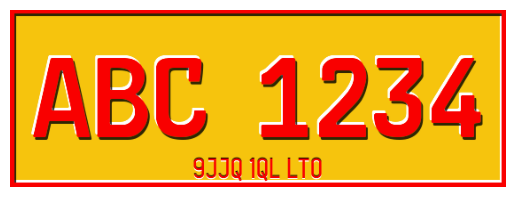

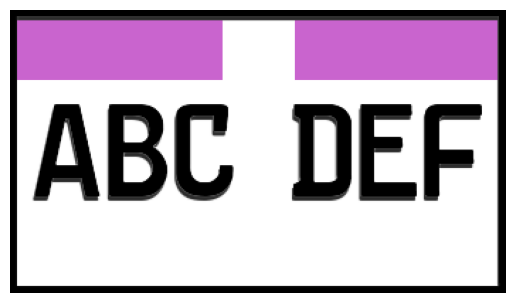

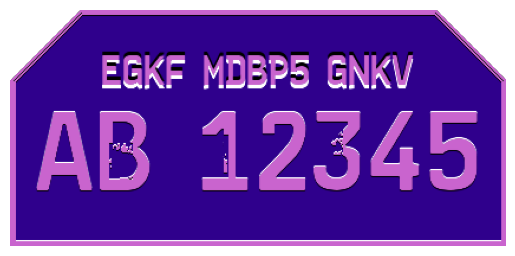

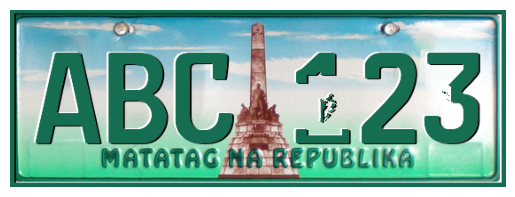

Annotations


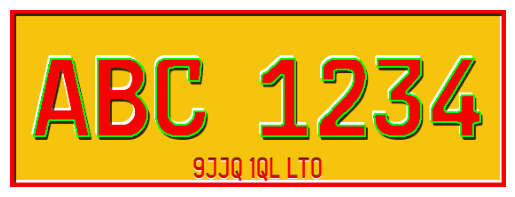

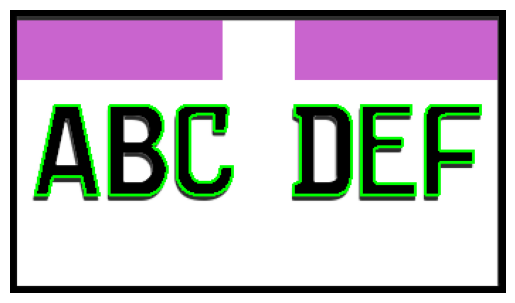

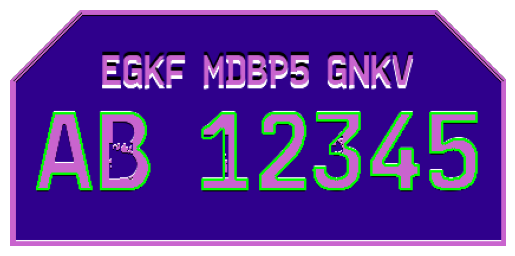

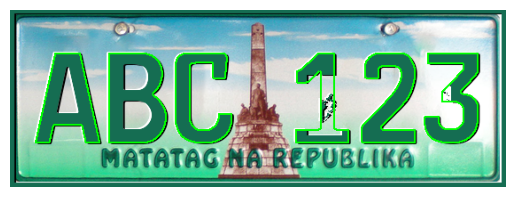

In [ ]:
# now we can finally create the plate methods


def create_vehicle_plate(color1, color2, font, text, enable_paint_chipping=False, enable_small_text=True):
    base = create_plate_base(vw, vh, color1, color2, border_thickness=0, has_bevel=False)

    content_layer = Image.new("RGBA", (vw, vh), (0, 0, 0, 0))
    d = ImageDraw.Draw(content_layer)

    # 1. Border
    for i in range(5):
        d.rectangle([i, i, vw - 1 - i, vh - 1 - i], outline=color1 + (255,))

    # 2. Text + annotations
    text_out = create_text_layer(font, text, vw, vh, color1, enable_paint_chipping=enable_paint_chipping)
    content_layer = Image.alpha_composite(content_layer, text_out["image"])

    # 3. Emboss once (border + text)
    content_layer = apply_random_emboss(content_layer)

    plate = Image.alpha_composite(base, content_layer)
    
    # 4. Add small text at bottom if enabled
    if enable_small_text:
        small_text = generate_dummy_text()
        plate = add_small_text(plate, small_text, position="bottom", color=color1)

    return {
        "image": plate,
        "annotations": text_out["annotations"]
    }

def create_motorcycle_plate(color, font, text, detailOnTop=True, enable_paint_chipping=False):
    base = create_plate_base(mw, mh, black, white, border_thickness=0, has_bevel=False)

    content_layer = Image.new("RGBA", (mw, mh), (0, 0, 0, 0))
    d = ImageDraw.Draw(content_layer)

    # 1. Border
    for i in range(5):
        d.rectangle([i, i, mw - 1 - i, mh - 1 - i], outline=black + (255,))

    # 2. Text + annotations
    text_out = create_text_layer(font, text, mw, mh, black, enable_paint_chipping=enable_paint_chipping)
    content_layer = Image.alpha_composite(content_layer, text_out["image"])

    # 3. Emboss
    content_layer = apply_random_emboss(content_layer)

    plate = Image.alpha_composite(base, content_layer)

    # 4. Details (flat, after emboss)
    rect_w, rect_h = int(72*debug_scale), int(22*debug_scale)
    offset = 5
    detail_layer = Image.new("RGBA", (mw, mh), (0, 0, 0, 0))
    dd = ImageDraw.Draw(detail_layer)

    if detailOnTop:
        dd.rectangle([offset, offset, offset + rect_w, offset + rect_h], fill=color + (255,))
        dd.rectangle([mw - offset - rect_w, offset, mw - offset, offset + rect_h], fill=color + (255,))
    else:
        dd.rectangle([offset, mh - offset - rect_h, offset + rect_w, mh - offset], fill=color + (255,))
        dd.rectangle([mw - offset - rect_w, mh - offset - rect_h, mw - offset, mh - offset], fill=color + (255,))

    plate = Image.alpha_composite(plate, ImageChops.darker(detail_layer, plate))

    return {
        "image": plate,
        "annotations": text_out["annotations"]
    }


def create_motorcycle_beveled_plate(color1, color2, font, text, enable_paint_chipping=False, enable_small_text=True):
    base = create_plate_base(maw, mah, color1, color2, border_thickness=0, has_bevel=True)

    content_layer = Image.new("RGBA", (maw, mah), (0, 0, 0, 0))
    d = ImageDraw.Draw(content_layer)

    # 1. Border polygon
    for i in range(5):
        shift = int(i * (math.sqrt(2) - 1))
        poly = [
            (i, corner + shift),
            (corner + shift, i),
            (maw - corner - shift, i),
            (maw - i, corner + shift),
            (maw - i, mah - i),
            (i, mah - i)
        ]
        d.polygon(poly, outline=color1 + (255,))

    # 2. Text + annotations
    text_out = create_text_layer(font, text, maw, mah, color1, enable_paint_chipping=enable_paint_chipping)
    shift_scale = 0.1
    shift_y = int(mah * shift_scale)
    shifted_image = Image.new("RGBA", (maw, mah), (0, 0, 0, 0))
    shifted_image.paste(text_out["image"], (0, shift_y), text_out["image"])
    # Shift annotation polygons as well
    shifted_annotations = []
    for ann in text_out["annotations"]:
        shifted_mask = Image.new("L", (maw, mah), 0)
        shifted_mask.paste(ann["mask"], (0, shift_y), ann["mask"])
        shifted_annotations.append({
            "character": ann["character"],
            "mask": shifted_mask
        })
    text_out["image"] = shifted_image
    text_out["annotations"] = shifted_annotations
    content_layer = Image.alpha_composite(content_layer, text_out["image"])

    # 3. Emboss (border + text)
    content_layer = apply_random_emboss(content_layer)

    # 4. Clip emboss artifacts to base shape
    base_alpha = base.split()[-1]
    content_alpha = content_layer.split()[-1]
    content_layer.putalpha(ImageChops.multiply(content_alpha, base_alpha))

    plate = Image.alpha_composite(base, content_layer)
    
    # 5. Add small text at top if enabled (changed from top_left to top)
    if enable_small_text:
        small_text = generate_dummy_text()
        plate = add_small_text(plate, small_text, position="top", color=color1)

    return {
        "image": plate,
        "annotations": text_out["annotations"]
    }

def create_rizal_plate(font, text, enable_paint_chipping=False):
    # Use the Rizal background image
    base = Image.open(r_background).convert("RGBA").resize((vw, vh), Image.Resampling.LANCZOS)

    # Content layer
    content_layer = Image.new("RGBA", (vw, vh), (0, 0, 0, 0))
    d = ImageDraw.Draw(content_layer)

    # Border (using r_green)
    for i in range(5):
        d.rectangle([i, i, vw - 1 - i, vh - 1 - i], outline=r_green + (255,))

    # Text + annotations (using r_green)
    text_out = create_text_layer(font, text, vw, vh, r_green, enable_paint_chipping=enable_paint_chipping)
    content_layer = Image.alpha_composite(content_layer, text_out["image"])

    # Emboss
    content_layer = apply_random_emboss(content_layer)

    plate = Image.alpha_composite(base, content_layer)

    return {
        "image": plate,
        "annotations": text_out["annotations"]
    }

# let's see how they look
print("Plate Images")
plate_img1 = create_vehicle_plate(v_red, v_yellow, fonts[0], "ABC 1234")
plot_image(plate_img1["image"])

plate_img2 = create_motorcycle_plate(m_pink, fonts[0], "ABC DEF", detailOnTop=True)
plot_image(plate_img2["image"])

plate_img3 = create_motorcycle_beveled_plate(m_pink, m_dark_blue, fonts[0], "AB 12345", enable_paint_chipping=True)
plot_image(plate_img3["image"])

plate_img4 = create_rizal_plate(fonts[0], "ABC 123", enable_paint_chipping=True)
plot_image(plate_img4["image"])

# Visualize all plate images with annotation overlays
print("Annotations")
all_polygons = convert_to_polygons(plate_img1["annotations"])
overlay_img = visualize_polygon_overlay(plate_img1["image"], all_polygons)
plot_image(overlay_img)

all_polygons = convert_to_polygons(plate_img2["annotations"])
overlay_img = visualize_polygon_overlay(plate_img2["image"], all_polygons)
plot_image(overlay_img)

all_polygons = convert_to_polygons(plate_img3["annotations"])
overlay_img = visualize_polygon_overlay(plate_img3["image"], all_polygons)
plot_image(overlay_img)

all_polygons = convert_to_polygons(plate_img4["annotations"])
overlay_img = visualize_polygon_overlay(plate_img4["image"], all_polygons)
plot_image(overlay_img)
